# Análise Exploratória: Umidade relativa em 12 estações de MG

12 estações meteorológicas, considerando os anos de 2018 a 2022.

## Importações

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [1]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)
# init_path = '/content/drive/My Drive/BDG-TP-2/Dados/'
init_path = '../CSV/'

## Funções para exploração

In [67]:
def read_and_format_df(csv, cod, nome, lat, lon):
  df = pd.read_csv(csv, sep=";", low_memory=False)
  df_filt = df[['DATA (YYYY-MM-DD)', 'HORA (UTC)',
       'UMIDADE RELATIVA DO AR. HORARIA (%)']].copy()
  df_filt.rename(columns={'UMIDADE RELATIVA DO AR. HORARIA (%)': 'umidade_hora'}, inplace=True)
  df_filt['datetime'] = df_filt['DATA (YYYY-MM-DD)'] + " " + df_filt['HORA (UTC)']
  df_filt = df_filt.drop(['DATA (YYYY-MM-DD)', 'HORA (UTC)'], axis=1)
  df_filt['datetime'] = pd.to_datetime(df_filt['datetime'])
  df_filt['cod'] = cod

  return df_filt

In [68]:
def check_and_delete_nan(df):
  cols = ['umidade_hora']
  for col in cols:
    print(f'Ocorrências de NaN na coluna {col}: {df[col].isna().sum()}')
  print(f'Número de linhas antes de remover nulos: {df.shape[0]}')
  df.dropna(how='any', inplace=True)
  print(f'Número de linhas depois de remover nulos: {df.shape[0]}\n')
  return df

In [69]:
def statistics(df, estacao):
  print('Resumo estatístico:')
  print(df.describe())
  plt.hist(df['umidade_hora'], bins=20, edgecolor='black')
  plt.axvline(np.mean(df['umidade_hora']), label = 'Média', color='mediumvioletred', linestyle='--')
  plt.title(estacao)
  plt.xlabel('Umidade relativa')
  plt.ylabel('Frequência')
  plt.xticks(list(range(0, 101, 10)))
  plt.legend()
  plt.show()

In [70]:
list_csv = []

In [71]:
def dias_secos_por_mes_estacao(df):
    dias_ano_regist = df.groupby(pd.Grouper(key='datetime', freq='1D')).count().reset_index()
    dias_ano_regist = dias_ano_regist[dias_ano_regist['umidade_hora'] > 0]
    dias_ano_regist = dias_ano_regist.groupby(pd.Grouper(key='datetime', freq='1Y')).count()['umidade_hora'].values
    min_dia = df.groupby(pd.Grouper(key='datetime', freq='1D')).min()
    num_dias_secos_ano = min_dia[min_dia['umidade_hora'] < 30]
    num_dias_secos_ano.reset_index(inplace=True)
    dias_secos_mes_gb = num_dias_secos_ano.groupby(pd.Grouper(key='datetime', freq='1Y')).count()
    num_dias_secos_mes = dias_secos_mes_gb['umidade_hora']
    return (num_dias_secos_mes.values / dias_ano_regist)

In [72]:
def media_umidade_min_por_mes_estacao(df):
    min_dia = df.groupby(pd.Grouper(key='datetime', freq='1D')).min()
    min_dia.reset_index(inplace=True)
    media_umid_min_mes = min_dia[['datetime', 'umidade_hora']].groupby(pd.Grouper(key='datetime', freq='1Y')).mean()
    return np.round(media_umid_min_mes.values.reshape(-1), 2)

In [73]:
def media_umidade_max_por_mes_estacao(df):
    max_dia = df.groupby(pd.Grouper(key='datetime', freq='1D')).max()
    max_dia.reset_index(inplace=True)
    media_umid_max_mes = max_dia[['datetime', 'umidade_hora']].groupby(pd.Grouper(key='datetime', freq='1Y')).mean()
    return np.round(media_umid_max_mes.values.reshape(-1), 2)

In [74]:
def make_row_estacao(df_orig, estacao, cod, lat, lon, list_csv):
    list_info = [cod, estacao, lat, lon]
    list_dias_secos_mes = dias_secos_por_mes_estacao(df_orig)
    list_med_umid_min_mes = media_umidade_min_por_mes_estacao(df_orig)
    list_med_umid_max_mes = media_umidade_max_por_mes_estacao(df_orig)
    l = [list_info, list_dias_secos_mes, list_med_umid_min_mes, list_med_umid_max_mes]

    flat_final_list = []
    for sublist in l:
        for item in sublist:
            flat_final_list.append(item)

    list_csv.append(flat_final_list)
    return flat_final_list

In [119]:
def plot_histograms(df, name):
    dias_ano_regist = df.groupby(pd.Grouper(key='datetime', freq='1D')).count().reset_index()
    dias_ano_regist = dias_ano_regist.groupby(pd.Grouper(key='datetime', freq='3MS')).count()['umidade_hora']
    index_datas = dias_ano_regist.index
    index_datas = [date+datetime.timedelta(days=45) for date in index_datas]


    dias_ano_regist = df.groupby(pd.Grouper(key='datetime', freq='1D')).count().reset_index()
    dias_ano_regist = dias_ano_regist[dias_ano_regist['umidade_hora'] > 0]
    dias_ano_regist = dias_ano_regist.groupby(pd.Grouper(key='datetime', freq='3MS')).count()['umidade_hora'].values
    min_dia = df.groupby(pd.Grouper(key='datetime', freq='1D')).min()
    num_dias_secos_ano = min_dia[min_dia['umidade_hora'] < 30]
    num_dias_secos_ano.reset_index(inplace=True)
    dias_secos_mes_gb = num_dias_secos_ano.groupby(pd.Grouper(key='datetime', freq='3MS')).count()
    num_dias_secos_mes = dias_secos_mes_gb['umidade_hora']
    dias_secos = num_dias_secos_mes.values / dias_ano_regist


    umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
    umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)

    plt.bar(x=index_datas, height=dias_secos, width=85)
    plt.title(f'Progressão de dias secos por trimestre em {name}')
    plt.ylabel('Proporção de dias secos')
    plt.xlabel('Tempo')
    plt.show()

    plt.bar(x=index_datas, height=umid_min_med, width=85)
    plt.title(f'Progressão da umidade mínima média por trimestre em {name}')
    plt.ylabel('Umidade mínima média')
    plt.xlabel('Tempo')
    plt.show()

    plt.bar(x=index_datas, height=umid_max_med, width=85)
    plt.title(f'Progressão da umidade máxima média por trimestre em {name}')
    plt.ylabel('Umidade máxima média')
    plt.xlabel('Tempo')
    plt.show()

## Análise por Estação

### Araxá

Ocorrências de NaN na coluna umidade_hora: 561
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 43263

Resumo estatístico:
       umidade_hora
count  43263.000000
mean      62.698010
std       18.881824
min       10.000000
25%       49.000000
50%       64.000000
75%       78.000000
max       95.000000


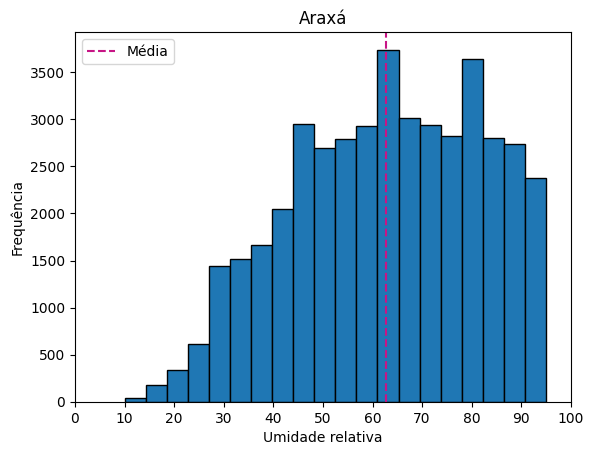

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


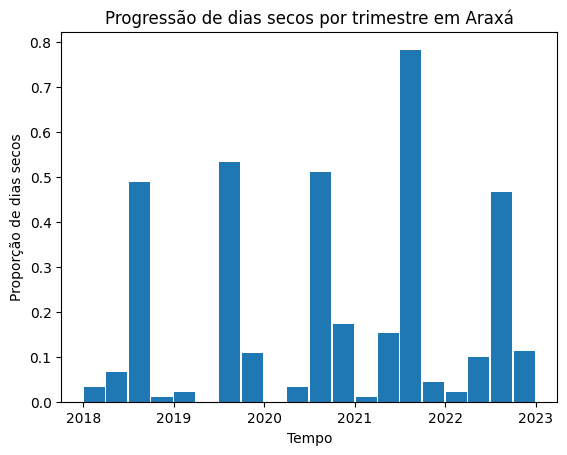

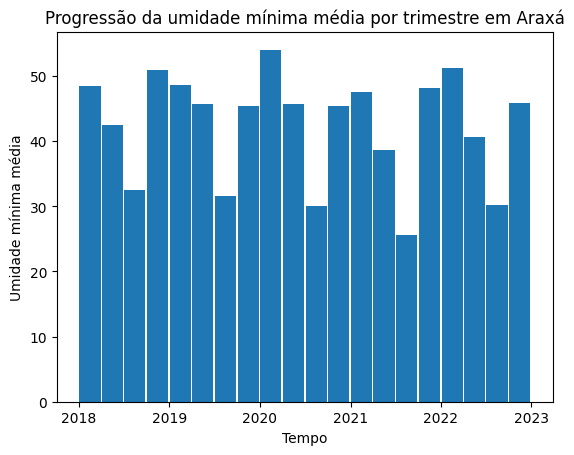

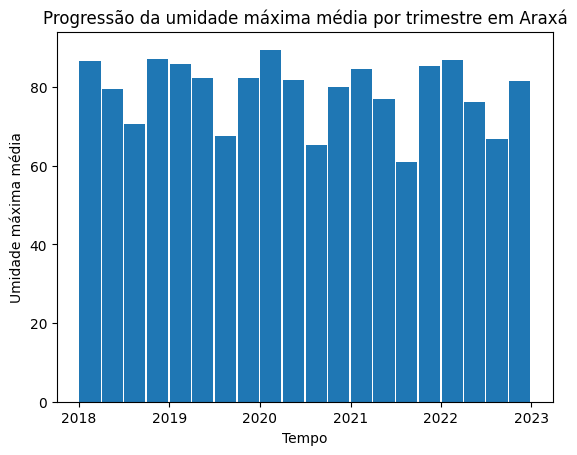

In [104]:
file_name = init_path + 'araxa.csv'
estacao = 'Araxá'
cod = 'A505'
lat = -19.60555555
lon = -46.94944444

df_araxa = read_and_format_df(file_name, cod, estacao, lat, lon)
df_araxa = check_and_delete_nan(df_araxa)

statistics(df_araxa, estacao)

_ = make_row_estacao(df_araxa, estacao, cod, lat, lon, list_csv)
plot_histograms(df_araxa, estacao)

### Bambuí

Ocorrências de NaN na coluna umidade_hora: 2377
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 41447

Resumo estatístico:
       umidade_hora
count  41447.000000
mean      77.616836
std       20.802862
min       12.000000
25%       61.000000
50%       85.000000
75%       96.000000
max      100.000000


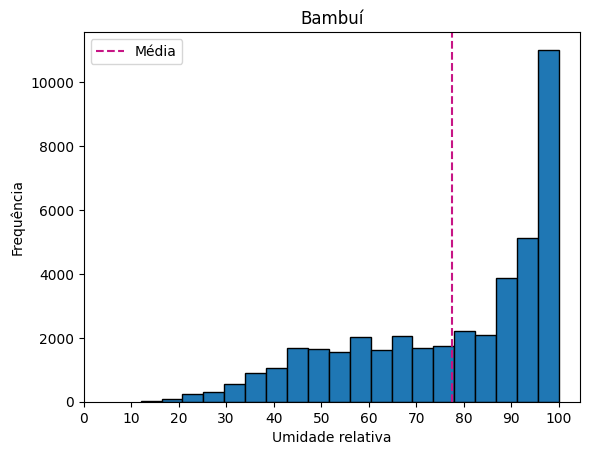

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


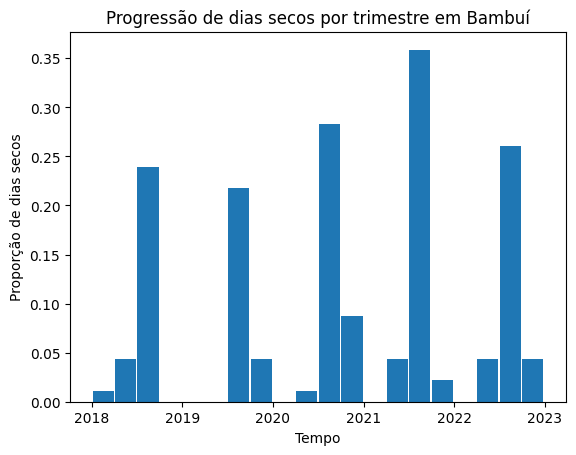

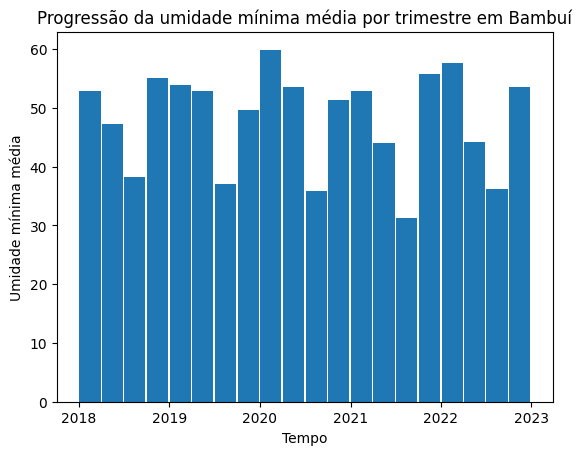

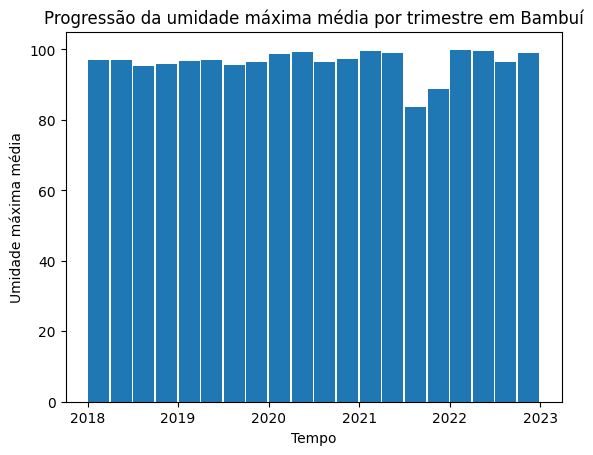

In [105]:
file_name = init_path + 'bambui.csv'
estacao = 'Bambuí'
cod = 'A565'
lat = -20.0311111
lon = -46.00861111

df_bambui = read_and_format_df(file_name, cod, estacao, lat, lon)
df_bambui = check_and_delete_nan(df_bambui)

statistics(df_bambui, estacao)

_ = make_row_estacao(df_bambui, estacao, cod, lat, lon, list_csv)
plot_histograms(df_bambui, estacao)

### Curvelo

Ocorrências de NaN na coluna umidade_hora: 4485
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 39339

Resumo estatístico:
       umidade_hora
count  39339.000000
mean      65.287501
std       20.760595
min       10.000000
25%       49.000000
50%       68.000000
75%       84.000000
max       99.000000


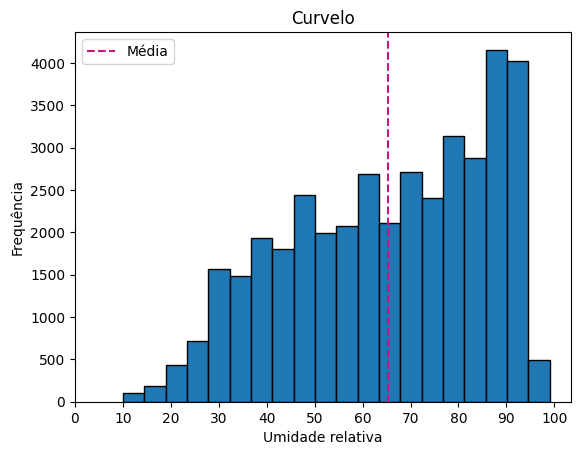

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


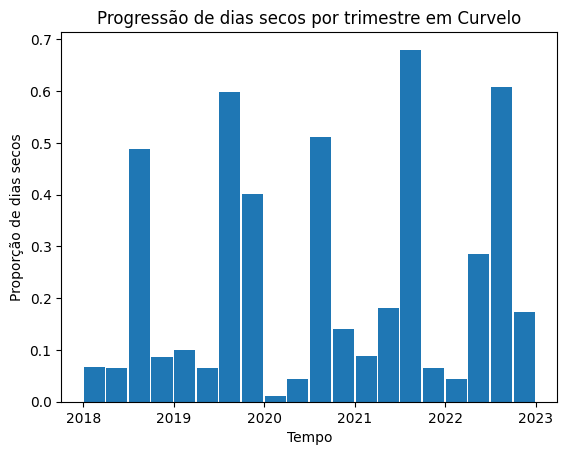

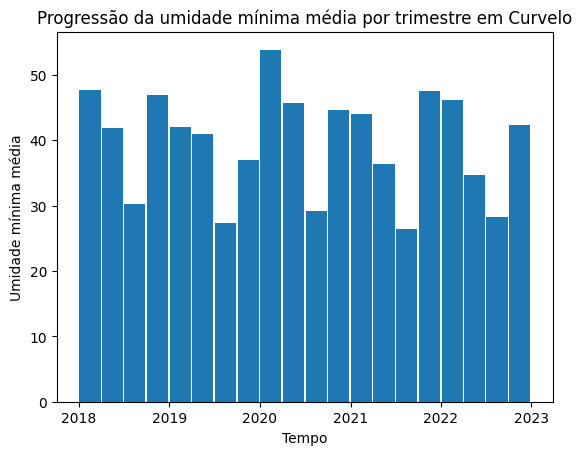

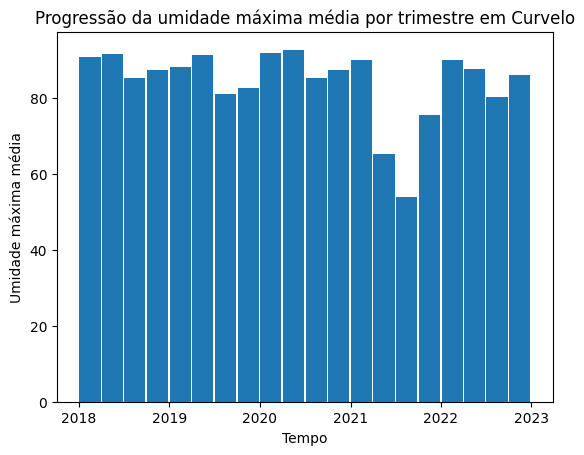

In [106]:
file_name = init_path + 'curvelo.csv'
estacao = 'Curvelo'
cod = 'A538'
lat = -18.76444444
lon = -44.45361111

df_curvelo = read_and_format_df(file_name, cod, estacao, lat, lon)
df_curvelo = check_and_delete_nan(df_curvelo)

statistics(df_curvelo, estacao)

_ = make_row_estacao(df_curvelo, estacao, cod, lat, lon, list_csv)
plot_histograms(df_curvelo, estacao)

### Diamantina

Ocorrências de NaN na coluna umidade_hora: 1787
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 42037

Resumo estatístico:
       umidade_hora
count  42037.000000
mean      73.733449
std       17.866616
min       10.000000
25%       61.000000
50%       77.000000
75%       89.000000
max       97.000000


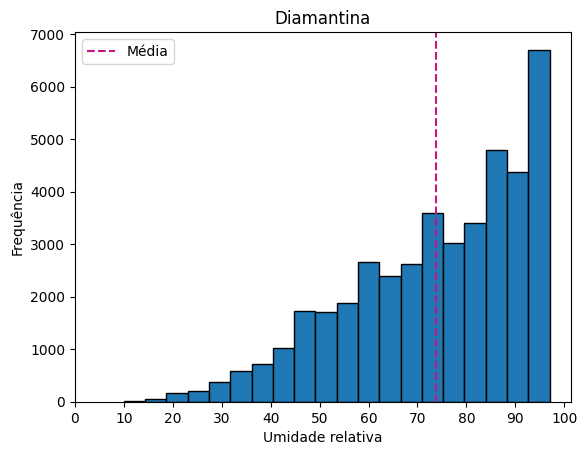

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


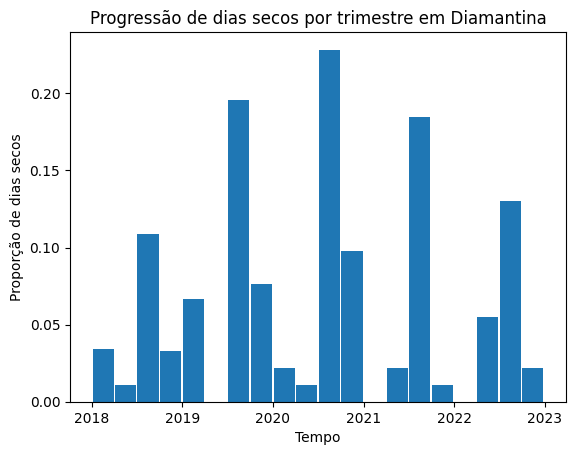

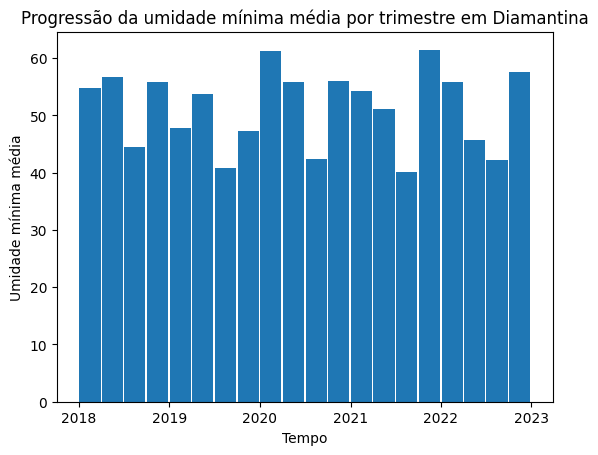

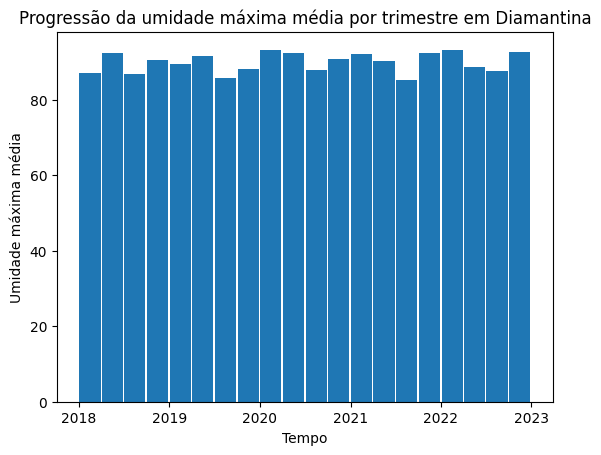

In [107]:
file_name = init_path + 'diamantina.csv'
estacao = 'Diamantina'
cod = 'A537'
lat = -18.2311111
lon = -43.64805555

df_diamantina = read_and_format_df(file_name, cod, estacao, lat, lon)
df_diamantina = check_and_delete_nan(df_diamantina)

statistics(df_diamantina, estacao)

_ = make_row_estacao(df_diamantina, estacao, cod, lat, lon, list_csv)
plot_histograms(df_diamantina, estacao)

### Divinópolis

Ocorrências de NaN na coluna umidade_hora: 57
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 43767

Resumo estatístico:
       umidade_hora
count  43767.000000
mean      72.451070
std       21.703158
min       13.000000
25%       55.000000
50%       75.000000
75%       93.000000
max      100.000000


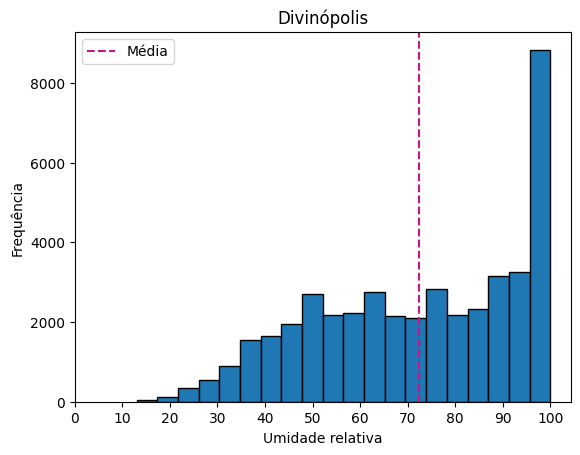

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


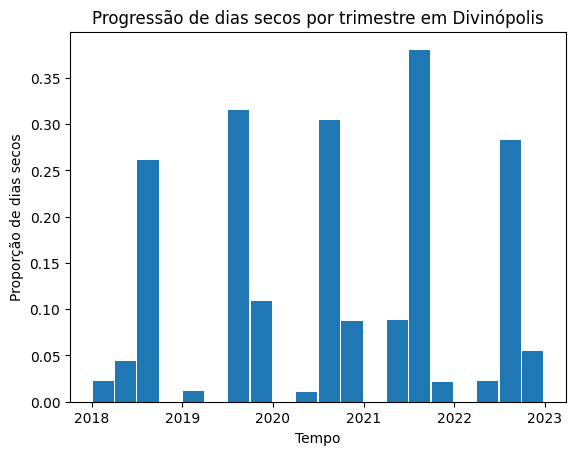

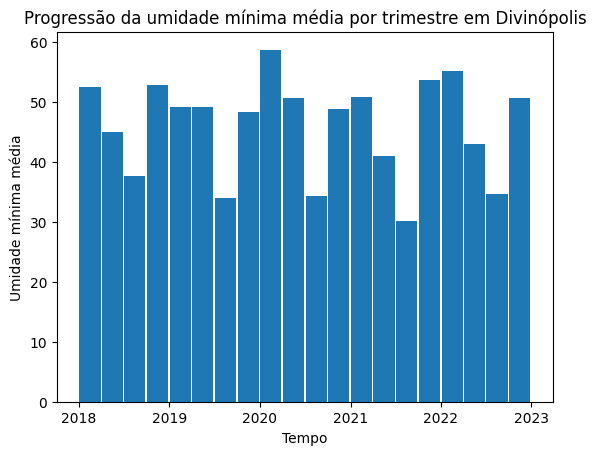

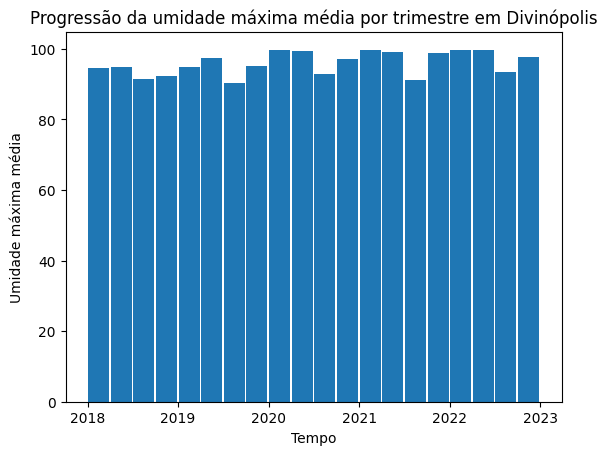

In [108]:
file_name = init_path + 'divinopolis.csv'
estacao = 'Divinópolis'
cod = 'A564'
lat = -20.17305554
lon = -44.87472221

df_divinopolis = read_and_format_df(file_name, cod, estacao, lat, lon)
df_divinopolis = check_and_delete_nan(df_divinopolis)

statistics(df_divinopolis, estacao)

_ = make_row_estacao(df_divinopolis, estacao, cod, lat, lon, list_csv)
plot_histograms(df_divinopolis, estacao)

### Dores do Indaiá

Ocorrências de NaN na coluna umidade_hora: 2202
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 41622

Resumo estatístico:
       umidade_hora
count  41622.000000
mean      66.294388
std       20.187748
min       11.000000
25%       51.000000
50%       68.000000
75%       84.000000
max       97.000000


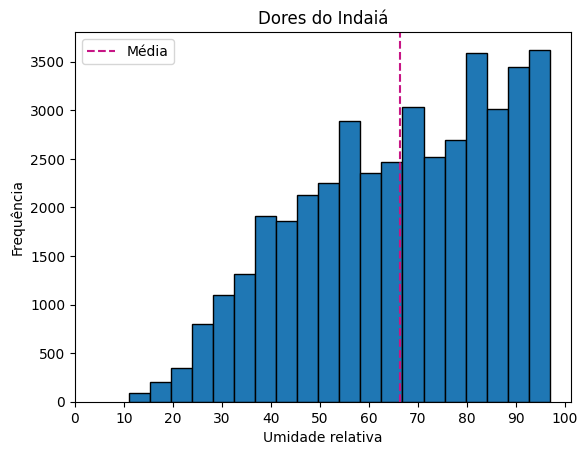

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


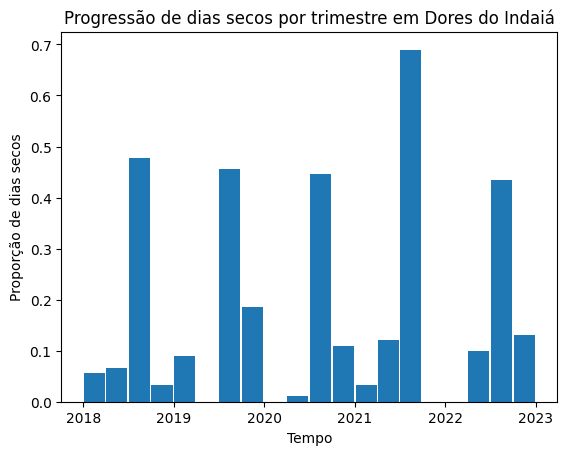

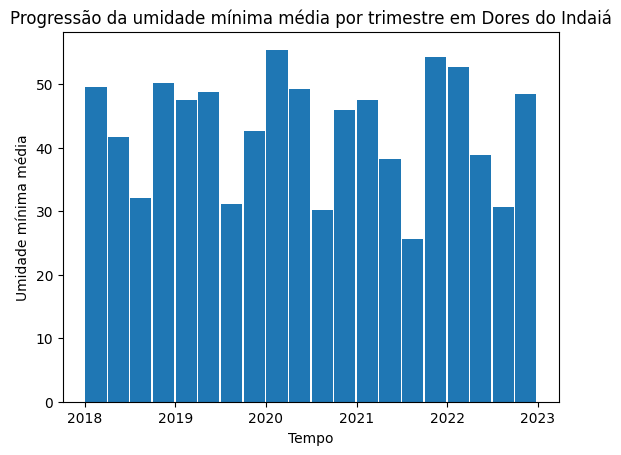

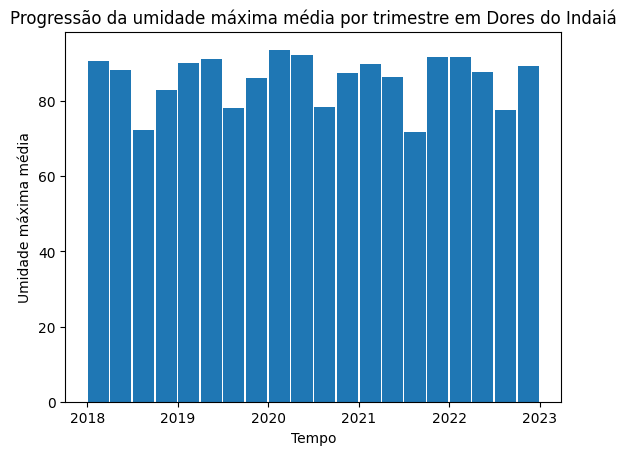

In [109]:
file_name = init_path + 'doresdoindaia.csv'
estacao = 'Dores do Indaiá'
cod = 'A536'
lat = -19.48166666
lon = -45.59388888

df_doresdoindaia = read_and_format_df(file_name, cod, estacao, lat, lon)
df_doresdoindaia = check_and_delete_nan(df_doresdoindaia)

statistics(df_doresdoindaia, estacao)

_ = make_row_estacao(df_doresdoindaia, estacao, cod, lat, lon, list_csv)
plot_histograms(df_doresdoindaia, estacao)

### Florestal

Ocorrências de NaN na coluna umidade_hora: 1818
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 42006

Resumo estatístico:
       umidade_hora
count   42006.00000
mean       72.18345
std        21.12214
min        11.00000
25%        55.00000
50%        78.00000
75%        92.00000
max        97.00000


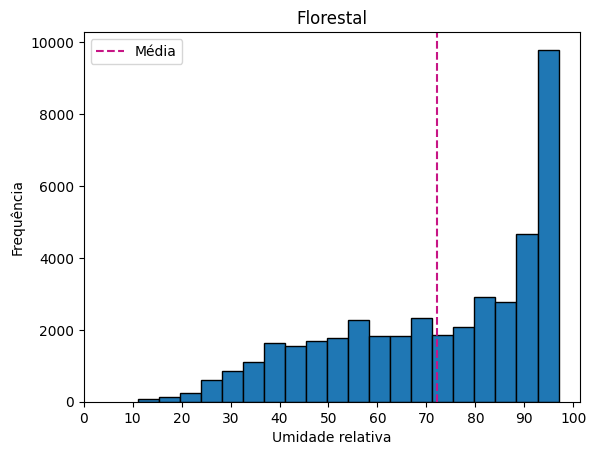

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


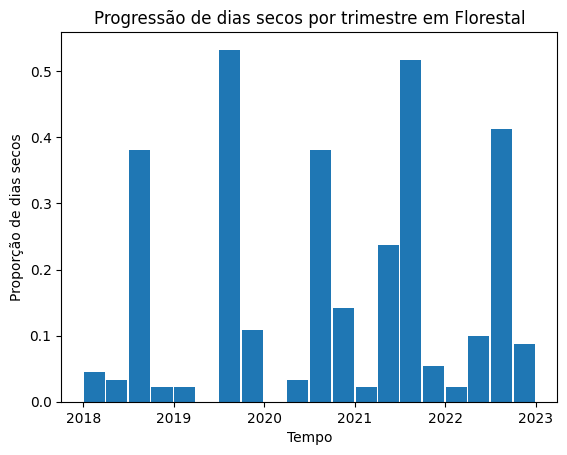

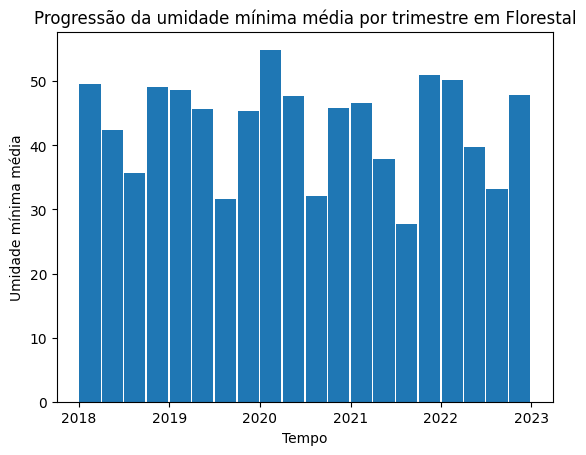

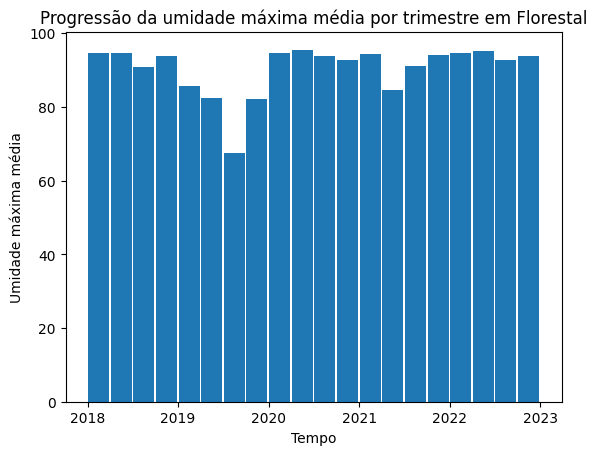

In [110]:
file_name = init_path + 'florestal.csv'
estacao = 'Florestal'
cod = 'A535'
lat = -19.88527778
lon = -44.41694444

df_florestal = read_and_format_df(file_name, cod, estacao, lat, lon)
df_florestal = check_and_delete_nan(df_florestal)

statistics(df_florestal, estacao)

_ = make_row_estacao(df_florestal, estacao, cod, lat, lon, list_csv)
plot_histograms(df_florestal, estacao)

### Pampulha (BH)

Ocorrências de NaN na coluna umidade_hora: 98
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 43726

Resumo estatístico:
       umidade_hora
count  43726.000000
mean      65.211682
std       17.403660
min       11.000000
25%       53.000000
50%       67.000000
75%       79.000000
max       93.000000


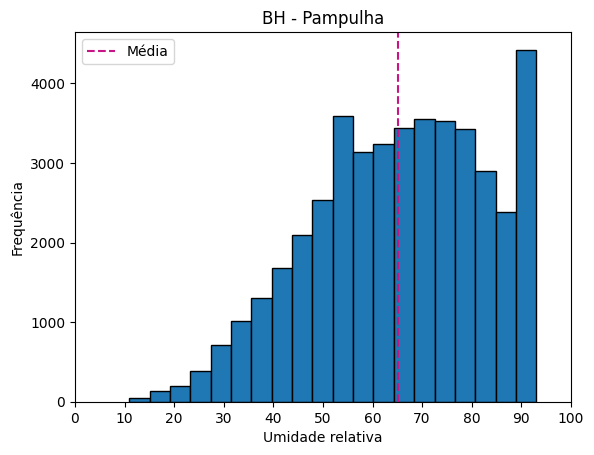

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


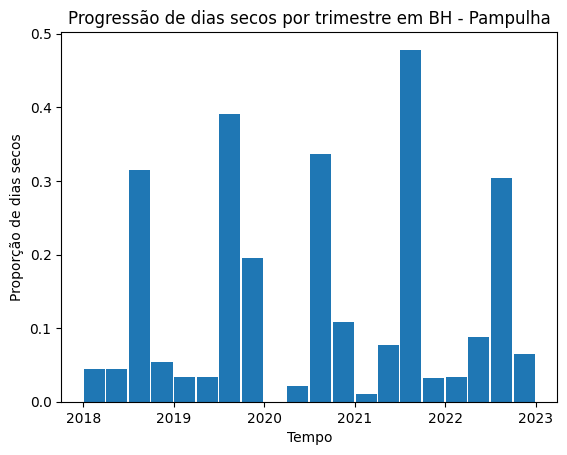

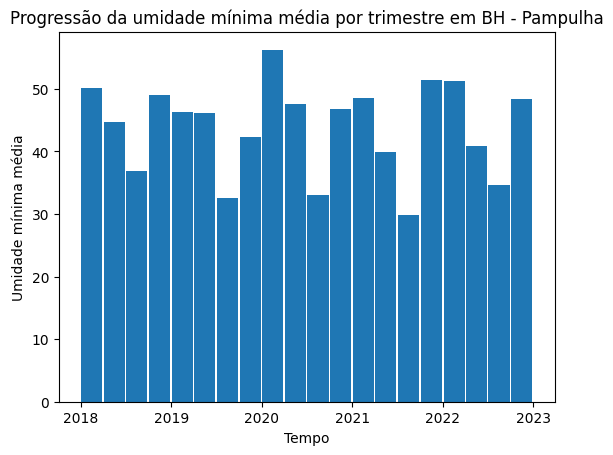

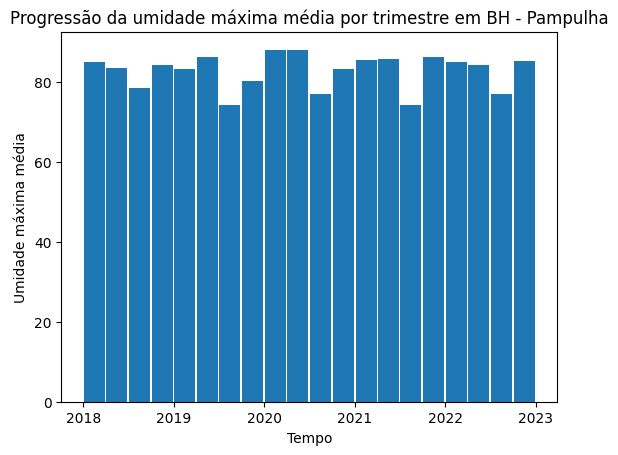

In [111]:
file_name = init_path + 'pampulha.CSV'
estacao = 'BH - Pampulha'
cod = 'A521'
lat = -19.88416666
lon = -43.96944443

df_bh = read_and_format_df(file_name, cod, estacao, lat, lon)
df_bh = check_and_delete_nan(df_bh)

statistics(df_bh, estacao)

_ = make_row_estacao(df_bh, estacao, cod, lat, lon, list_csv)
plot_histograms(df_bh, estacao)

### Patos de Minas

Ocorrências de NaN na coluna umidade_hora: 4983
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 38841

Resumo estatístico:
       umidade_hora
count  38841.000000
mean      66.205118
std       20.340258
min        8.000000
25%       51.000000
50%       68.000000
75%       84.000000
max       97.000000


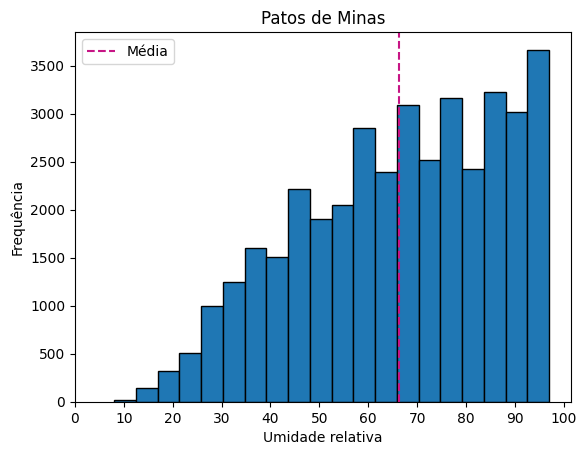

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


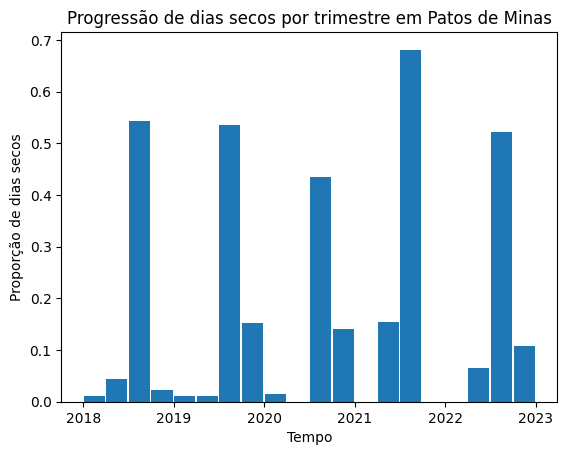

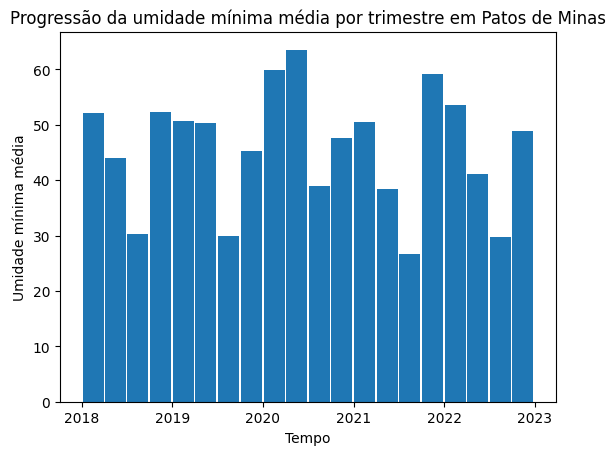

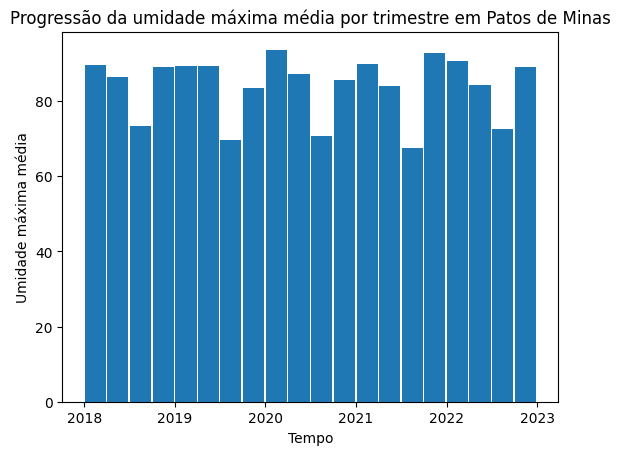

In [112]:
file_name = init_path + 'patos_de_minas.CSV'
estacao = 'Patos de Minas'
cod = 'A562'
lat = -18.52055554
lon = -46.44055555

df_patos_de_minas = read_and_format_df(file_name, cod, estacao, lat, lon)
df_patos_de_minas = check_and_delete_nan(df_patos_de_minas)

statistics(df_patos_de_minas, estacao)

_ = make_row_estacao(df_patos_de_minas, estacao, cod, lat, lon, list_csv)
plot_histograms(df_patos_de_minas, estacao)

### Patrocínio

Ocorrências de NaN na coluna umidade_hora: 1576
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 42248

Resumo estatístico:
       umidade_hora
count  42248.000000
mean      72.997018
std       22.083635
min        9.000000
25%       56.000000
50%       78.000000
75%       93.000000
max      100.000000


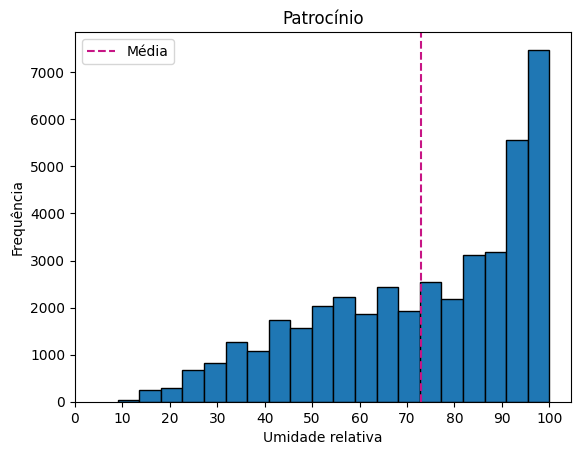

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


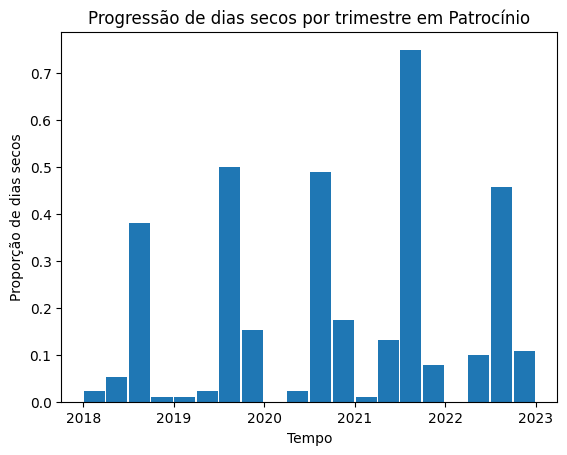

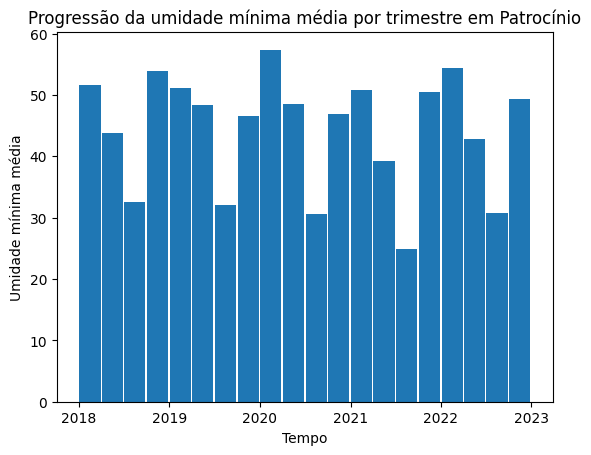

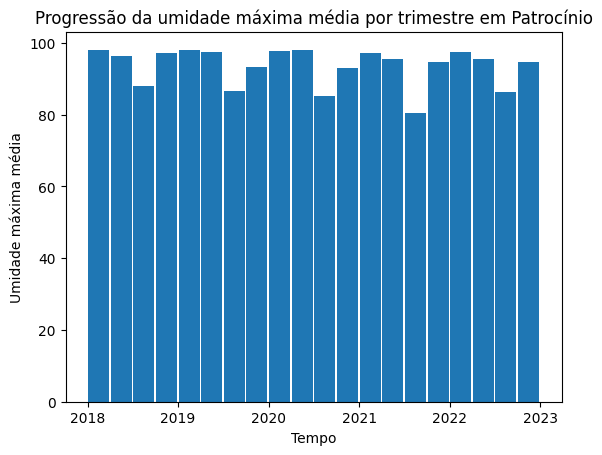

In [113]:
file_name = init_path + 'patrocinio.CSV'
estacao = 'Patrocínio'
cod = 'A523'
lat = -18.99638888
lon = -46.98583333

df_patrocinio = read_and_format_df(file_name, cod, estacao, lat, lon)
df_patrocinio = check_and_delete_nan(df_patrocinio)

statistics(df_patrocinio, estacao)

_ = make_row_estacao(df_patrocinio, estacao, cod, lat, lon, list_csv)
plot_histograms(df_patrocinio, estacao)

### Sete Lagoas

Ocorrências de NaN na coluna umidade_hora: 4452
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 39372

Resumo estatístico:
       umidade_hora
count  39372.000000
mean      69.974703
std       21.108524
min       10.000000
25%       53.000000
50%       74.000000
75%       89.000000
max      100.000000


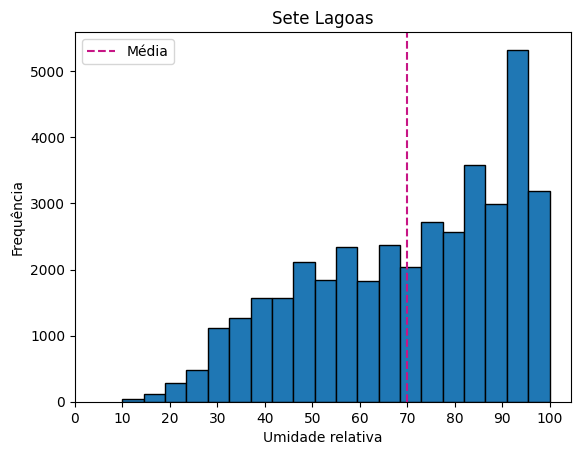

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


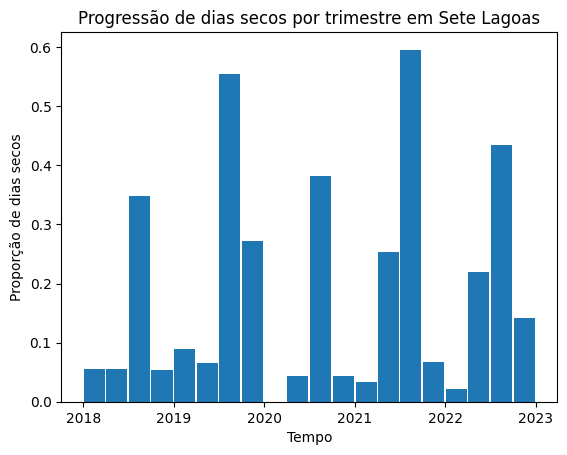

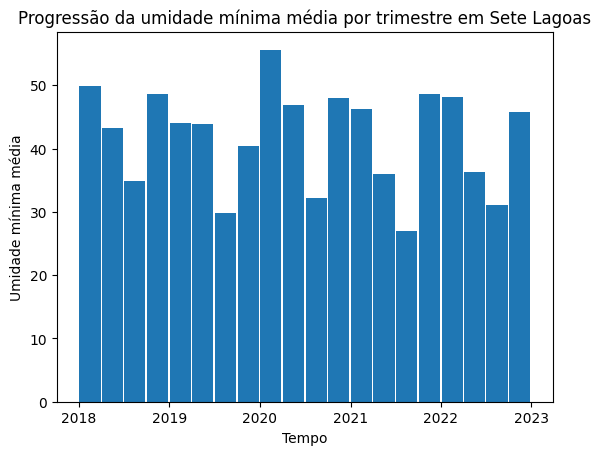

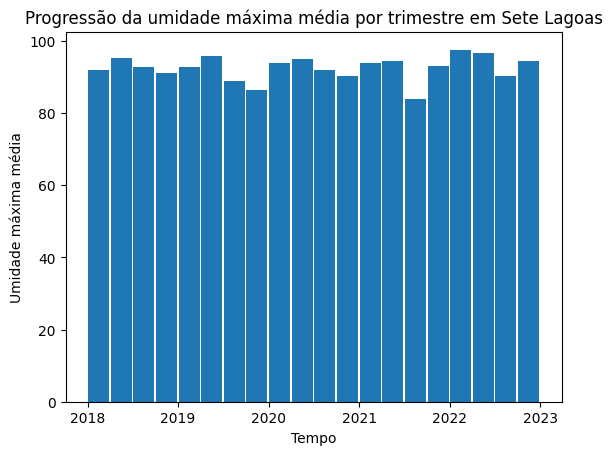

In [114]:
file_name = init_path + 'sete_lagoas.csv'
estacao = 'Sete Lagoas'
cod = 'A569'
lat = -19.455
lon = -44.17333332

df_sete_lagoas = read_and_format_df(file_name, cod, estacao, lat, lon)
df_sete_lagoas = check_and_delete_nan(df_sete_lagoas)

statistics(df_sete_lagoas, estacao)

_ = make_row_estacao(df_sete_lagoas, estacao, cod, lat, lon, list_csv)
plot_histograms(df_sete_lagoas, estacao)

### Três Marias

Ocorrências de NaN na coluna umidade_hora: 336
Número de linhas antes de remover nulos: 43824
Número de linhas depois de remover nulos: 43488

Resumo estatístico:
       umidade_hora
count  43488.000000
mean      65.064340
std       19.864159
min        9.000000
25%       51.000000
50%       66.000000
75%       81.000000
max       96.000000


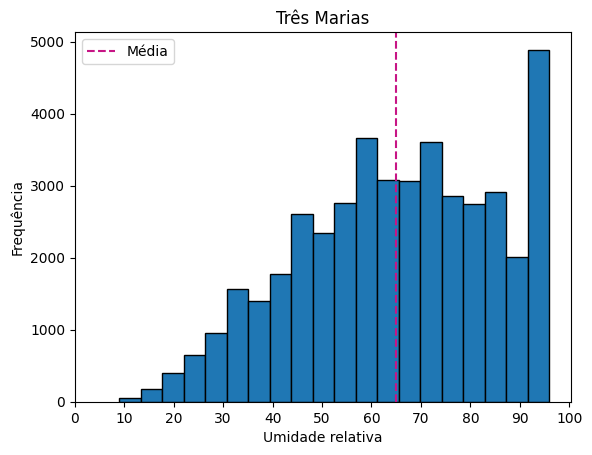

<ipython-input-103-1142d59c270d>:19: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_min_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).min().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)
<ipython-input-103-1142d59c270d>:20: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  umid_max_med = df.groupby(pd.Grouper(key='datetime', freq='1D')).max().reset_index().groupby(pd.Grouper(key='datetime', freq='3MS')).mean().values.reshape(-1)


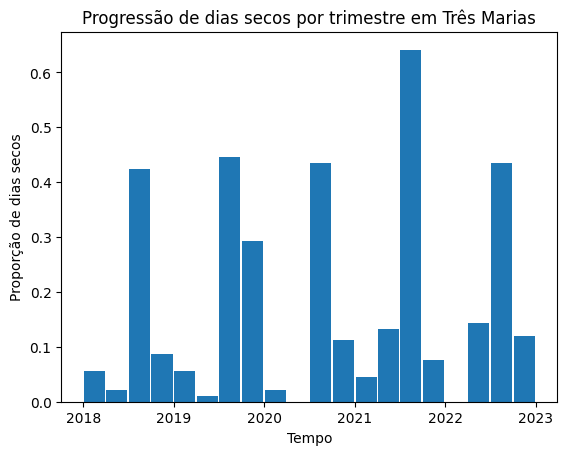

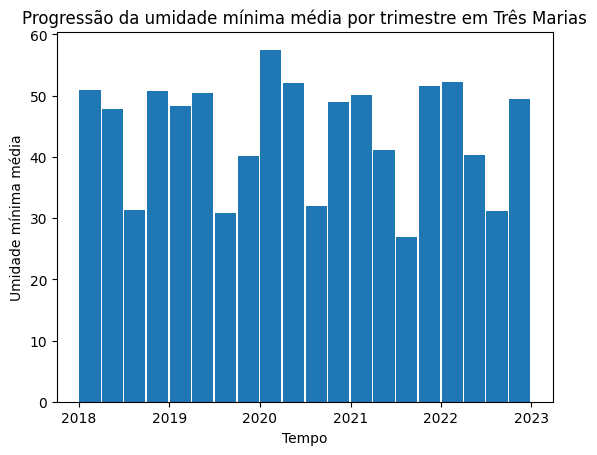

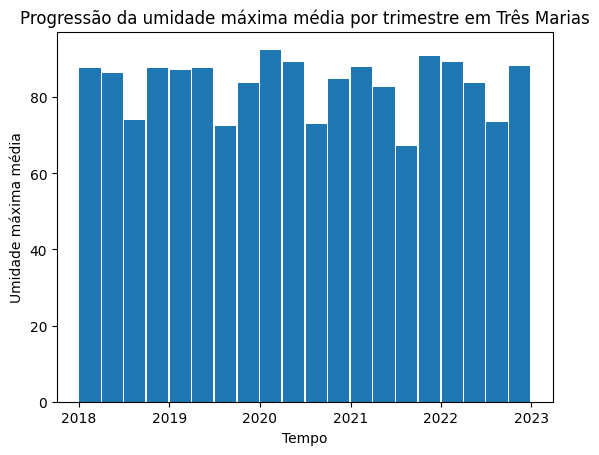

In [115]:
file_name = init_path + 'tres_marias.CSV'
estacao = 'Três Marias'
cod = 'A528'
lat = -18.20055555
lon= -45.45972222

df_tres_marias = read_and_format_df(file_name, cod, estacao, lat, lon)
df_tres_marias = check_and_delete_nan(df_tres_marias)

statistics(df_tres_marias, estacao)

_ = make_row_estacao(df_tres_marias, estacao, cod, lat, lon, list_csv)
plot_histograms(df_tres_marias, estacao)

## Geração dos CSVs finais

In [116]:
anos = ['2018', '2019', '2020', '2021', '2022']

In [117]:
colunas_info = ['cod', 'nome', 'lat', 'lon']
colunas_dias_secos = ['DiasSecos_' + ano for ano in anos]
colunas_umid_min = ['MedUmidMin_' + ano for ano in anos]
colunas_umid_max = ['MedUmidMax_' + ano for ano in anos]
lista = [colunas_info, colunas_dias_secos, colunas_umid_min, colunas_umid_max]

flat_final_list = []
for sublist in lista:
    for item in sublist:
        flat_final_list.append(item)

In [118]:
geo_df = pd.DataFrame(list_csv, columns = flat_final_list)
geo_df

,cod,nome,lat,lon,DiasSecos_2018,DiasSecos_2019,DiasSecos_2020,DiasSecos_2021,DiasSecos_2022,MedUmidMin_2018,MedUmidMin_2019,MedUmidMin_2020,MedUmidMin_2021,MedUmidMin_2022,MedUmidMax_2018,MedUmidMax_2019,MedUmidMax_2020,MedUmidMax_2021,MedUmidMax_2022
0,A505,Araxá,-19.605556,-46.949444,0.150685,0.167123,0.180328,0.249315,0.176796,43.59,42.76,43.77,39.94,41.91,80.98,79.45,79.12,76.90,77.78
1,A565,Bambuí,-20.031111,-46.008611,0.073973,0.065753,0.095628,0.108033,0.087671,48.32,48.31,50.12,45.87,47.86,96.28,96.38,97.88,92.68,98.76
2,A538,Curvelo,-18.764444,-44.453611,0.178082,0.293151,0.177596,0.244514,0.279452,41.63,36.78,43.27,38.89,37.85,88.75,85.87,89.31,72.14,85.99
3,A537,Diamantina,-18.231111,-43.648056,0.046832,0.084932,0.090164,0.054795,0.052055,52.90,47.40,53.80,51.73,50.32,89.27,88.72,91.06,90.03,90.53
4,A564,Divinópolis,-20.173056,-44.874722,0.082192,0.109589,0.101093,0.123288,0.090411,46.98,45.14,48.14,43.86,45.81,93.25,94.41,97.29,97.21,97.62
5,A536,Dores do Indaiá,-19.481667,-45.593889,0.155125,0.183562,0.142077,0.231250,0.167123,43.46,42.45,45.12,40.00,42.58,83.60,86.33,87.90,84.24,86.56
6,A535,Florestal,-19.885278,-44.416944,0.120548,0.167123,0.139344,0.204819,0.156164,44.15,42.76,45.10,41.11,42.73,93.48,79.45,94.14,91.68,94.06
7,A521,BH - Pampulha,-19.884167,-43.969444,0.115068,0.164384,0.117486,0.150685,0.123288,45.14,41.81,45.85,42.39,43.72,82.91,81.06,84.12,82.92,82.94
8,A562,Patos de Minas,-18.520556,-46.440556,0.156164,0.172702,0.173633,0.201320,0.175342,44.61,44.27,50.77,42.96,43.26,84.51,83.11,83.17,83.48,84.12
9,A523,Patrocínio,-18.996389,-46.985833,0.123867,0.172603,0.172131,0.258160,0.167123,45.61,44.45,45.79,40.57,44.27,94.80,93.77,93.42,91.65,93.50


In [ ]:
geo_df.to_csv(f'{init_path}geo_df.csv', index=False)